# Experiment 02: Deformations Experiments  ETH-03


In this notebook, we are using the CLUST Dataset.
The sequence used for this notebook is ETH-03.zip


In [1]:
import sys
import random
import os
sys.path.append('../src')
import warnings
warnings.filterwarnings("ignore") 
from PIL import Image
from sklearn.manifold import Isomap
from utils.compute_metrics import get_metrics, get_majority_vote,log_test_metrics
from utils.split import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold
from tqdm import tqdm
from pprint import pprint
import torch
from itertools import product
import pickle
import pandas as pd
import numpy as np
import mlflow
import matplotlib.pyplot as plt
#from kymatio.numpy import Scattering2D

import torch
from tqdm import tqdm
import kymatio
from kymatio.torch import Scattering2D


# 1. Visualize Sequence of US
We are visualizing the first images from the sequence ETH-01-1 that contains 3652 US images.

In [3]:
directory=os.listdir('../data/02_interim/Data3')
directory.sort()

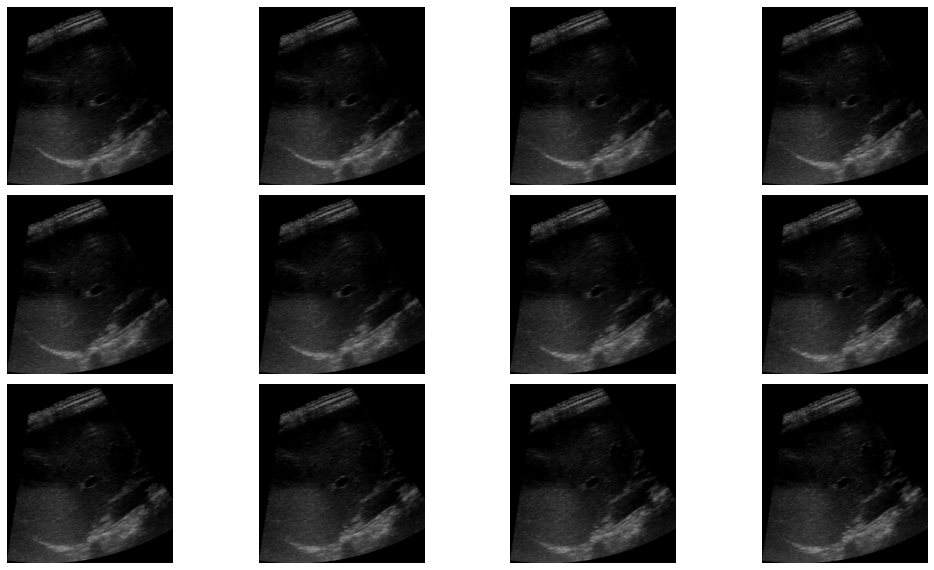

In [4]:
# settings
h, w = 15, 10        # for raster image
nrows, ncols = 3, 4  # array of sub-plots
figsize = [15, 8]     # figure size, inches

# prep (x,y) for extra plotting on selected sub-plots
xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
ys = np.abs(np.sin(xs))           # absolute of sine

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

imgs= directory[0:100]
count = 0
# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    img =plt.imread("../data/02_interim/Data3/" + imgs[i])
    axi.imshow(img, cmap='gray')
    axi.axis('off')
    # get indices of row/column
    # write row/col indices as axes' title for identification
    #axi.set_title(df_labels['Finding Labels'][row[count]], size=20)
    count = count +1


plt.tight_layout(True)
plt.savefig('samples_xray')
plt.show()

# 2. Create Dataset

In [5]:
%%time
ll_imgstemp = [plt.imread("../data/02_interim/Data3/" + dir) for dir in directory[:5]]

CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 17.1 ms


In [6]:
%%time
ll_imgs = [np.array(Image.open("../data/02_interim/Data3/" + dir).resize(size=(98, 114)), dtype='float32') for dir in directory]

CPU times: user 1.97 s, sys: 982 ms, total: 2.95 s
Wall time: 27.1 s


In [7]:
%%time
ll_imgs2 = [img.reshape(1,img.shape[0],img.shape[1]) for img in ll_imgs]

CPU times: user 1.11 ms, sys: 801 µs, total: 1.91 ms
Wall time: 1.91 ms


In [8]:
# dataset = pd.DataFrame([torch.tensor(ll_imgs).view(1,M,N).type(torch.float32)], columns='img')
dataset = pd.DataFrame({'img':ll_imgs2}).reset_index().rename(columns={'index':'order'})
# dataset = pd.DataFrame({'img':ll_imgs}).reset_index().rename(columns={'index':'order'})


In [ ]:
dataset

# 3. Extract Scattering Features

In [9]:
M,N = dataset['img'].iloc[0].shape[1], dataset['img'].iloc[0].shape[2]
print(M,N)

114 98


In [10]:
# Set the parameters of the scattering transform.
J = 3
# Generate a sample signal.
scattering = Scattering2D(J, (M, N))
data = np.concatenate(dataset['img'],axis=0)
data = torch.from_numpy(data)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda: 
    scattering = scattering.cuda()
    data = data.to(device)

In [11]:
init = 0
final =0
count =0
first_loop = True
for i in tqdm(range (0,len(data), 11)):
    init= i
    final = i + 11
    if first_loop:
        scattering_features = scattering(data[init: final])
        first_loop=False
        torch.cuda.empty_cache()
    else: 
        scattering_features = torch.cat((scattering_features,scattering(data[init: final]) ))
        torch.cuda.empty_cache()
#     break  
# save scattering features
# with open('../data/03_features/scattering_features_deformation.pickle', 'wb') as handle:
#     pickle.dump(scattering_features, handle, protocol=pickle.HIGHEST_PROTOCOL)     

100%|██████████| 418/418 [00:33<00:00, 12.33it/s]


In [12]:
# save scattering features
with open('../data/03_features/scattering_features_deformation3.pickle', 'wb') as handle:
    pickle.dump(scattering_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# save scattering features
with open('../data/03_features/dataset_deformation3.pickle', 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 4. Extract PCA Components

In [ ]:
with open('../data/03_features/scattering_features_deformation.pickle', 'rb') as handle:
    scattering_features = pickle.load(handle)
with open('../data/03_features/dataset_deformation.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [ ]:
sc_features = scattering_features.view(scattering_features.shape[0], scattering_features.shape[1] * scattering_features.shape[2] * scattering_features.shape[3])
X = sc_features.cpu().numpy()
#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=50)           
X = pca.fit_transform(X)

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


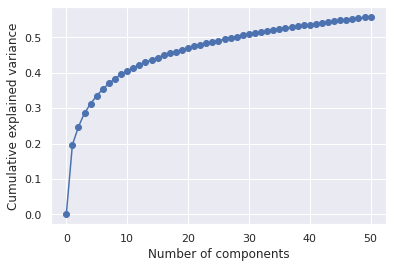

In [51]:
plt.plot(np.insert(pca.explained_variance_ratio_.cumsum(),0,0),marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [46]:
print(pca.explained_variance_ratio_.cumsum())

[0.19624099 0.24759144 0.28621092 0.31252828 0.3351434  0.3537408
 0.36981523 0.38349864 0.39517137 0.40505642 0.41383404 0.4221884
 0.42982128 0.436558   0.44279018 0.44873485 0.45440114 0.4597902
 0.46502966 0.469773   0.47435403 0.47868168 0.48280284 0.48682088
 0.4907649  0.49447757 0.4981357  0.50166786 0.50509644 0.5083065
 0.51140934 0.51437825 0.5173027  0.5201319  0.522938   0.5257039
 0.528359   0.53096086 0.53348184 0.53588855 0.5382833  0.5406142
 0.5429218  0.54518014 0.5474107  0.5495842  0.55175287 0.5538663
 0.55588806 0.5579046 ]


/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
df = pd.DataFrame(X)
df['order'] = dataset['order']
#df.corr()

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


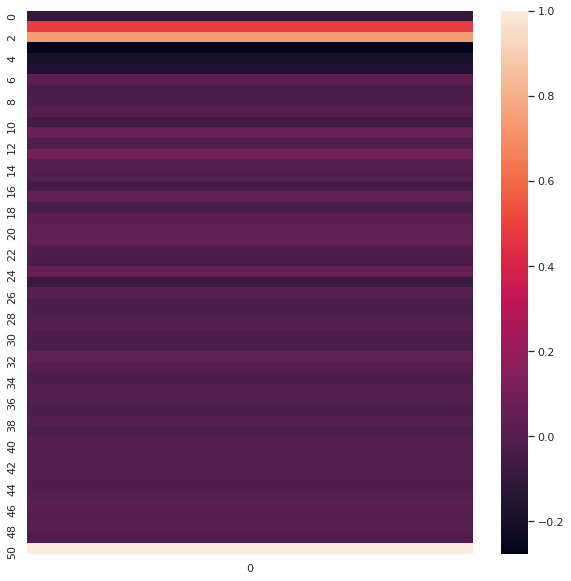

In [24]:
import seaborn as sns; sns.set_theme()
plt.figure(figsize = (10,10))
vec1 = df.corr()['order'].values
vec2 = vec1.reshape(vec1.shape[0], 1)
sns.heatmap(vec2)
plt.show()

In [25]:
def visualize_corr_pca_order(pca_c, df):
    plt.figure(figsize=(16,8))
    x= df['order']
    y= df[pca_c]
    plt.scatter(x,y)
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color='red')
    plt.ylabel('PCA Component '+ str(pca_c+1))
    plt.xlabel('Frame Order')
    plt.show()

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


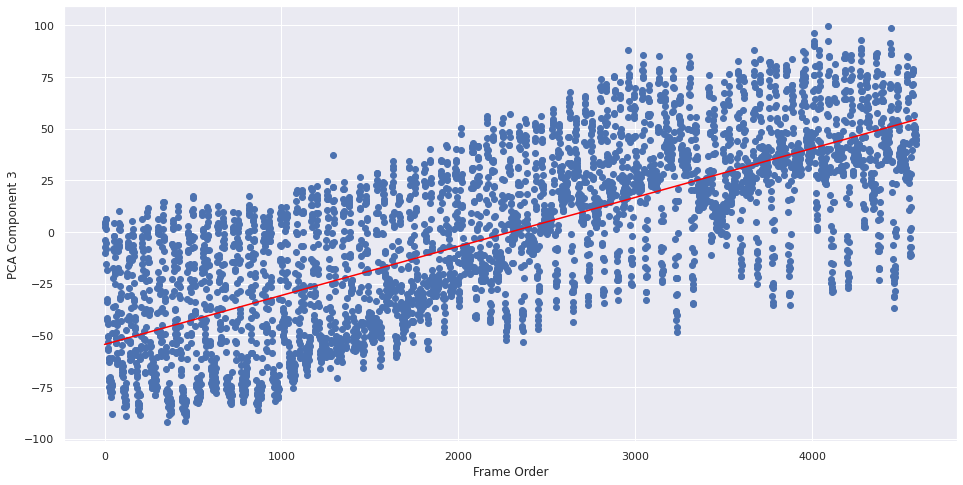

Correlation between order and Pca component 2: 0.7429257045405233


In [29]:
visualize_corr_pca_order(2, df)
print('Correlation between order and Pca component 2:', df.corr()['order'][2])

In [30]:
def visualize_sub_plot(pca_c, df,  x_num= 3, y_num =3):
    fig, axs = plt.subplots(x_num, y_num, figsize=(15,10))
    size = len(df)
    plot_num = x_num * y_num
    frame = int(size/plot_num)
    start = 0
    for i in range (x_num):
        for j in range (y_num):     
            final = start + frame
            x= df['order'].iloc[start:final]
            y= df[pca_c].iloc[start:final]
            m, b = np.polyfit(x, y, 1)

            axs[i, j].set_ylabel('PCA Component '+ str(pca_c+1))
            axs[i, j].set_xlabel('Frame Order')
            axs[i, j].plot(x, m*x + b, color='red')
            axs[i, j].scatter(x,y)
            start = start + frame
    plt.show()


/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


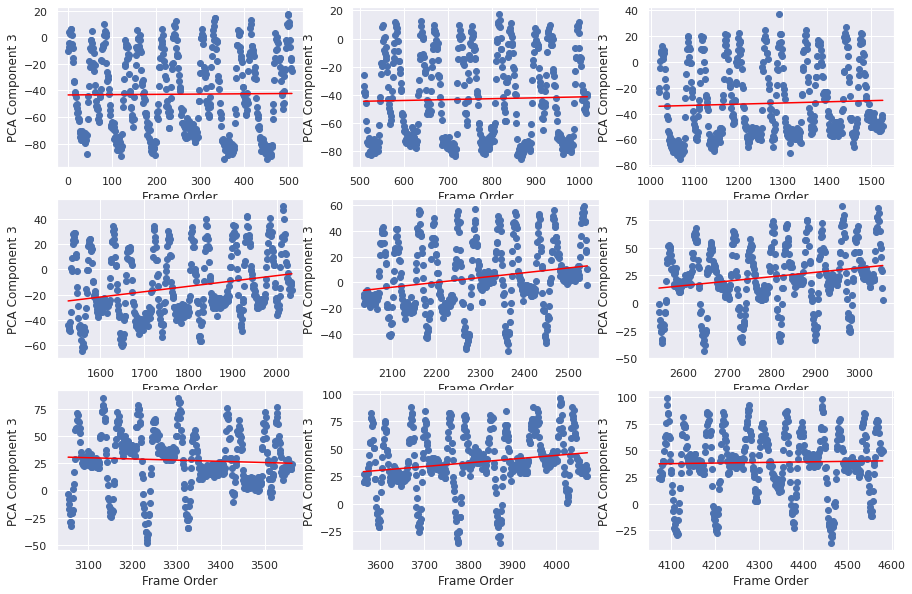

In [31]:
visualize_sub_plot(2, df,  x_num= 3, y_num =3)

# 5. Isometric Mapping Correlation with Order

In [37]:
with open('../data/03_features/scattering_features_deformation3.pickle', 'rb') as handle:
    scattering_features = pickle.load(handle)
with open('../data/03_features/dataset_deformation.pickle3', 'rb') as handle:
    dataset = pickle.load(handle)

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
sc_features = scattering_features.view(scattering_features.shape[0], scattering_features.shape[1] * scattering_features.shape[2] * scattering_features.shape[3])
X = sc_features.cpu().numpy()
#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [39]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(X[0:500])
df = pd.DataFrame(X_transformed)
df['order'] = dataset['order']

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
df.corr()

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,order
0,1.000000e+00,3.225204e-17,0.011833
1,3.225204e-17,1.000000e+00,-0.521879
order,1.183346e-02,-5.218792e-01,1.000000


In [41]:
from sklearn.manifold import Isomap
def visualize_sub_plot_iso(pca_c, x_num= 3, y_num =3):
    fig, axs = plt.subplots(x_num, y_num, figsize=(15,13))
    size =len(sc_features )
    plot_num = x_num * y_num
    frame = int(size/plot_num)
    start = 0
    for i in tqdm(range (x_num)):
        for j in tqdm(range (y_num)):     
            final = start + frame
            embedding = Isomap(n_components=2)
            X_transformed = embedding.fit_transform(X[start:final])
            df = pd.DataFrame(X_transformed)
            df['order'] = dataset['order'].iloc[start:final].values
            x= df['order']
            y= df[pca_c]
            start = start + frame
            
            #m, b = np.polyfit(x, y, 1)

            axs[i, j].set_ylabel('Iso Map Dimension '+ str(pca_c+1))
            axs[i, j].set_xlabel('Frame Order')
            #axs[i, j].plot(x, m*x + b, color='red')
            axs[i, j].scatter(x,y)
    plt.show()

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100%|██████████| 3/3 [02:44<00:00, 54.92s/it]


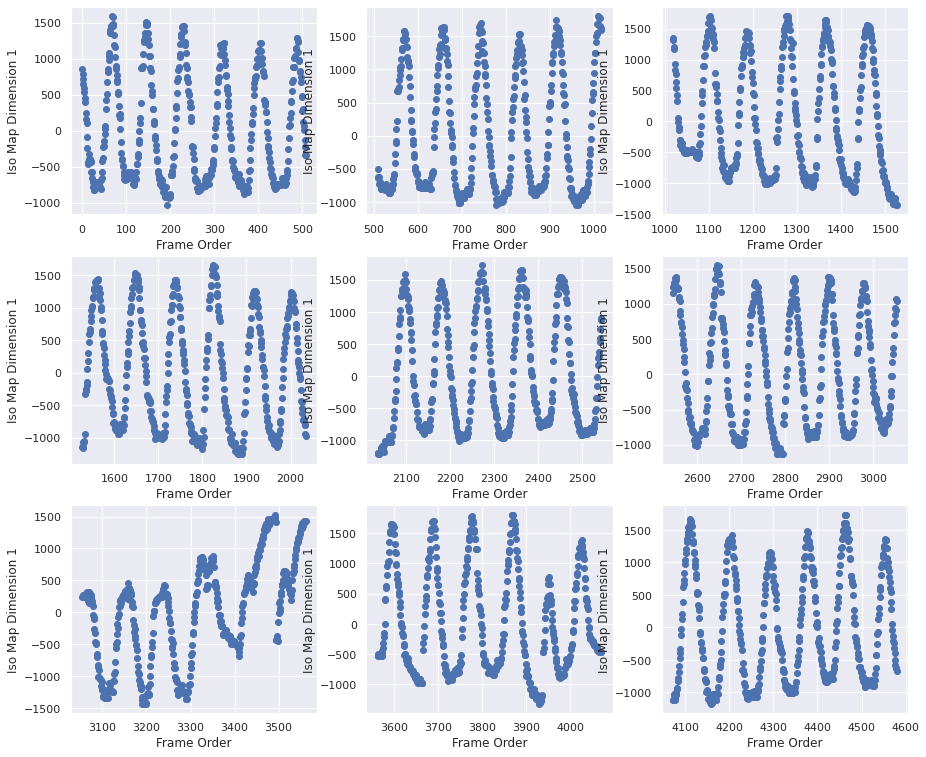

In [42]:
visualize_sub_plot_iso(0, x_num= 3, y_num =3)
#print('Correlation between order and Pca component 2:', df.corr()['order'][1])